In [ ]:

# ДЗ
# 1. Подберите параметры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.
# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.
# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

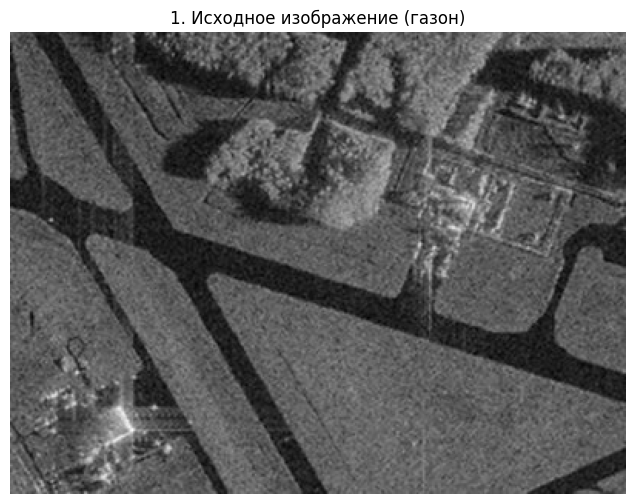

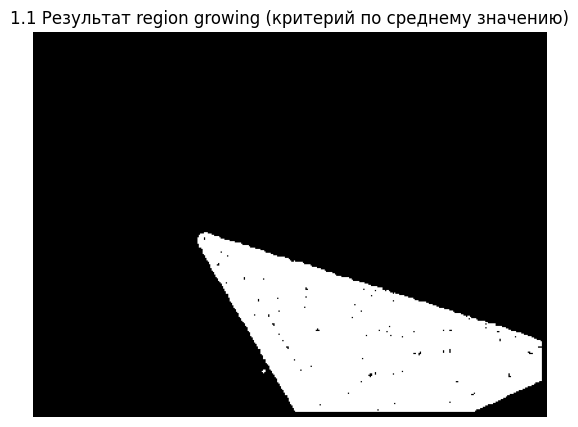

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import util, measure

image_path = 'sar_1_1.jpg'
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Файл {image_path} не найден.")

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_gray_f = util.img_as_float(image_gray)

plt.figure(figsize=(8, 6))
plt.imshow(image_gray, cmap='gray')
plt.title("1. Исходное изображение (газон)")
plt.axis('off')
plt.show()


def homo_average(img, mask, point, T):
    """Классический критерий — разница между средним по региону и текущим пикселем."""
    masked_region = img[mask > 0]
    if len(masked_region) == 0:
        return False
    av_val = masked_region.mean()
    return abs(av_val - img[point]) <= T


def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image.shape, np.uint8)
    mask[seed_point] = 1
    count = 1

    while count > 0:
        count = 0
        local_mask = np.zeros(image.shape, np.uint8)
        for i in range(r, image.shape[0] - r):
            for j in range(r, image.shape[1] - r):
                if mask[i, j] == 0 and mask[i - r:i + r, j - r:j + r].sum() > 0:
                    if homo_fun(image, mask, (i, j), T):
                        local_mask[i, j] = 1
        count = np.count_nonzero(local_mask)
        mask += local_mask

    return mask * 255


seed_point = (250, 250)
mask_avg = region_growing(image_gray, seed_point, homo_average, r=4, T=25)

plt.figure(figsize=(10, 5))
plt.imshow(mask_avg, cmap='gray')
plt.title("1.1 Результат region growing (критерий по среднему значению)")
plt.axis('off')
plt.show()

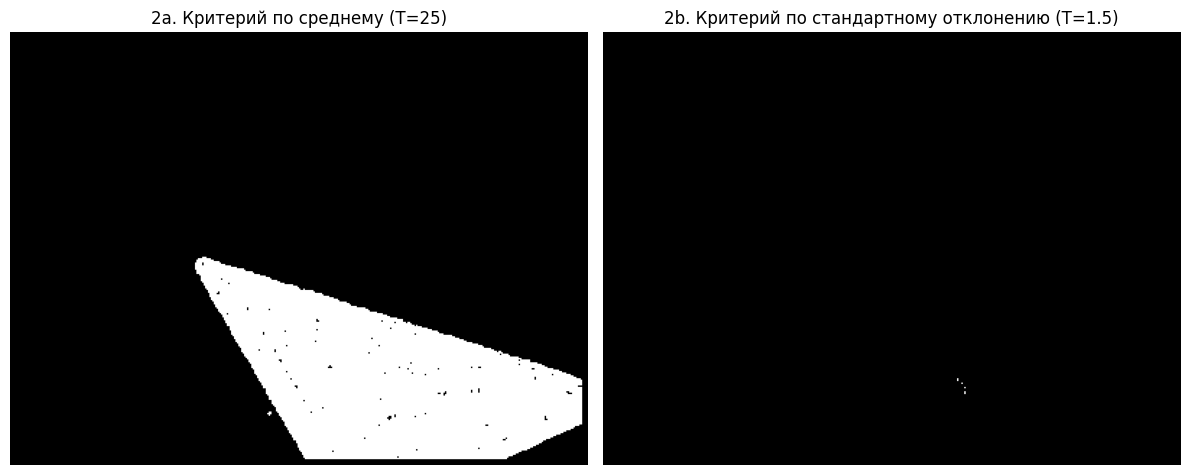

Площадь сегментации (по среднему): 20771 пикселей
Площадь сегментации (по σ-критерию): 6 пикселей


In [2]:
def homo_std(img, mask, point, T):
    """Новый критерий: проверка попадания пикселя в диапазон ±σ от среднего региона."""
    masked_region = img[mask > 0]
    if len(masked_region) == 0:
        return False
    mean_val = masked_region.mean()
    std_val = masked_region.std()
    return abs(img[point] - mean_val) <= T * (std_val + 1e-5)


mask_std = region_growing(image_gray, seed_point, homo_std, r=4, T=1.5)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(mask_avg, cmap='gray')
plt.title("2a. Критерий по среднему (T=25)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_std, cmap='gray')
plt.title("2b. Критерий по стандартному отклонению (T=1.5)")
plt.axis('off')

plt.tight_layout()
plt.show()

area_avg = np.count_nonzero(mask_avg)
area_std = np.count_nonzero(mask_std)
print(f"Площадь сегментации (по среднему): {area_avg} пикселей")
print(f"Площадь сегментации (по σ-критерию): {area_std} пикселей")

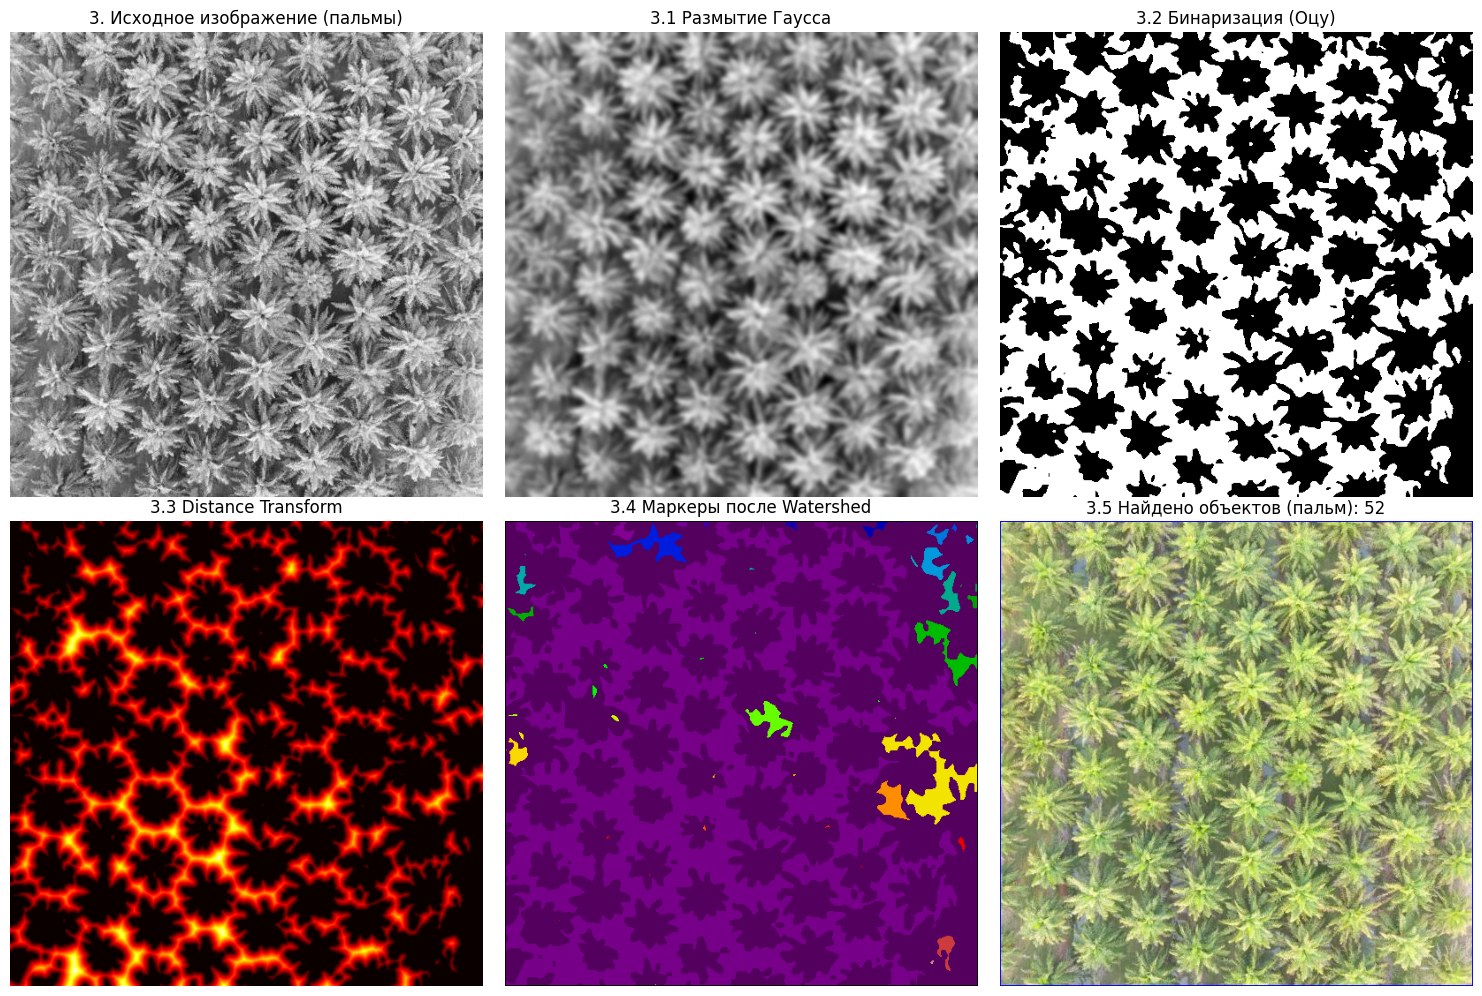

In [3]:
image_path_palm = 'palm_1.JPG'
image_palm = cv2.imread(image_path_palm)
if image_palm is None:
    raise FileNotFoundError(f"Файл {image_path_palm} не найден.")

image_gray_palm = cv2.cvtColor(image_palm, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.imshow(image_gray_palm, cmap='gray')
plt.title("3. Исходное изображение (пальмы)")
plt.axis('off')

blurred = cv2.GaussianBlur(image_gray_palm, (13, 13), 0)
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

plt.subplot(2, 3, 2)
plt.imshow(blurred, cmap='gray')
plt.title("3.1 Размытие Гаусса")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(thresh, cmap='gray')
plt.title("3.2 Бинаризация (Оцу)")
plt.axis('off')

dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

plt.subplot(2, 3, 4)
plt.imshow(dist_transform, cmap='hot')
plt.title("3.3 Distance Transform")
plt.axis('off')

_, sure_fg = cv2.threshold(dist_transform, 0.1 * dist_transform.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)

ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1  

markers_ws = cv2.watershed(image_palm, markers)
segmented = image_palm.copy()
segmented[markers_ws == -1] = [255, 0, 0]  
num_regions = len(np.unique(markers_ws)) - 2  

plt.subplot(2, 3, 5)
plt.imshow(markers_ws, cmap='nipy_spectral')
plt.title("3.4 Маркеры после Watershed")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
plt.title(f"3.5 Найдено объектов (пальм): {num_regions}")
plt.axis('off')

plt.tight_layout()
plt.show()
